<img src="resources/header.png"/>

# Gaussian Process hyperparameter inference as probabilistic program synthesis
Authored by: Ulli Schaechtle, Ph.D. of the MIT Probabilistic Computing Project (Probcomp). Prepared for: Probcomp's workshop at the O'Reilly Media AI Conference, June 27, 2017, New York City.

## Outline

1. Introduction
2. Training data
3. Probabilistic programming synthesis prior & model
4. Observe data & setting structure
5. Inference
    1. Metropolis-Hastings (MH)
    2. Gradient ascent
    3. Comparison of MH and gradient ascent
7. References

## 1. Introduction

Recent work by [1] and [2] showed it is possible
to use Gaussian Processes (GPs) to discover covariance structure in univariate
time series. 
We have implemented the approach from
[1] by using probabilistic program synthesis for Bayesian
learning over the symbolic structure of GP covariance kernels.
The technique is implemented in under 150 lines of Venture code, shown
[below](hyperparameter-inference-with-gp.ipynb#Main-probabilstic-program-synthesis-prior).  Find our full paper on [time series structure discovery via probabilistic program synthesis on ArXiv](https://arxiv.org/abs/1611.07051).

#### Goal of this notebook

In this notebook, we demonstrate hyperparameter inference in the probabilistic programming synthesis framework. 
We compare Metropolis-Hastings sampling and gradient ascent as two synthesis
strategies for inference over GP hyperparameters.
The training data used for learning are drawn from a GP with a  periodic kernel
with length scale 3. and period 3. 


#### Gaussian processes

We briefly review the Gaussian process, a nonparametric regression technique
that learns a function $f: \mathcal{X} \to \mathcal{Y}$. The GP prior can
express both simple parametric forms (such as polynomial functions), as well as
more complex relationships dictated by periodicity, smoothness, and so on.
Following the notations from [3], we formalize a Gaussian
process $f \sim \mathcal{GP}(m, k)$ with mean function $m: \mathcal{X} \to 
\mathcal{Y}$ and covariance function $k:
\mathcal{X} \times \mathcal{X} \to \mathbb{R}$ as a
collection of random variables $\{f(x): x \in \mathcal{X}\}$, any finite
subcollection $[f(x_1), \dots, f(x_n)]$ of which are jointly Gaussian with mean
vector $[m(x_1),\dots,m(x_n)]$ and covariance matrix
$[k(x_i,x_j)]_{1\le{i,j}\le{n}}$. While the mean function $m$ is typically set
to zero (as it can be expressed through covariance), the covariance kernel $k$
captures the essential features of the unknown function $f$, which are its
ability to (i) fit patterns in the data, and (ii) generalize to out-of-sample
predictions. Rich GP kernels can be created by composing simple (base) kernels
through sum, product, and changepoint operators [3, Section 4.2.4].

#### Starting VentureScript

Start the jupyter-probcomp extensions.

In [1]:
%%capture
%load_ext jupyter_probcomp.magics
%matplotlib inline

Load the Read Infer Predict Layer (RIPL) and set Venture's random seed to 7 to
ensure reproducibility.

In [2]:
%ripl --seed 7 --plugins resources/python/gp_synth_plugins.py

Set seed of a new VentureScript RIPL to 7.00.
Loading plugin: resources/python/gp_synth_plugins.py


## 2. Training data

We load the training data into the notebook.
We also load held-out data, which later will serve to cross-check the
hyperparameters found by different inference strategies.

In [3]:
%%venturescript
define observed_input = load_csv("resources/synthetic_data/x_training.csv");
define observed_output = load_csv("resources/synthetic_data/y_training.csv");
define held_out_input = load_csv("resources/synthetic_data/x_test.csv");
define held_out_output = load_csv("resources/synthetic_data/y_test.csv");

Next, we plot the training data.
To plot, we supply a VentureScript dictionary that that mirrors the
keyword-argument structure of python's matplotlib.

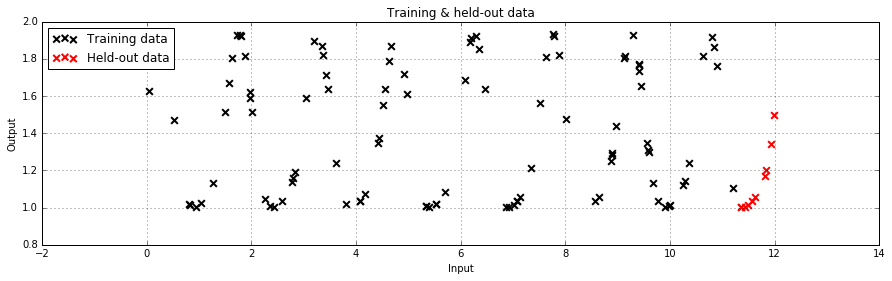

In [4]:
%%venturescript
define plotting_args_scatter = dict(
        ["xlabel", "Input"],
        ["ylabel", "Output"],
        ["label", "Training data"],
        ["title", "Training & held-out data"],
        ["markersize", 45],
        ["width", 15],
        ["height", 4],
        ["color", "black"]
);
define plotting_args_scatter_held_out = dict(
        ["label", "Held-out data"],
        ["markersize", 45],
        ["color", "red"]
);
scatter_plot(observed_input, observed_output, plotting_args_scatter);
scatter_plot(held_out_input, held_out_output, plotting_args_scatter_held_out);
legend("upper left");

**Figure 1: training data.**
The training data, drawn from a GP with a periodic kernel a periodic
kernel with lengthscale 3. and period 3. Held-out data are drawn in red.
Can you see a periodic trend in the training data?

## 3. Probabilistic programming synthesis prior & model 

Next, we run the probabilistic program synthesis model/prior.

#### Hyperparameter prior

We define `get_hyper_prior` as a function implements a "gradient-safe" hyperprior
for hyperparameters. We omit details about what this means here but the
interested reader can find an explanation [here](resources/gradient-safe-hyperpriors.ipynb).

In [5]:
%%venturescript
assume get_hyper_prior ~ mem((node_index) -> {
    -log_logistic(log_odds_uniform() #hypers:node_index)
});

$
\newcommand{\dnin}{d^\textrm{in}}
\newcommand{\dnout}{d^\textrm{out}}
\newcommand{\Kprior}{\mathbf{K}^{\textrm{cov}}}
\newcommand{\abs}[1]{\left\lvert #1 \right\rvert}
$
#### Synthesis Model
We now describe the synthesis model ([abstract syntax tree (AST)](https://en.wikipedia.org/wiki/Abstract_syntax_tree) prior and AST interpreter), and the
class of synthesized model programs for learning GP covariance structures.
The AST prior $\mathcal{G}$ specifies a prior over binary trees.
Each leaf $n$ of $\mathcal{T}$ is a pair $(k_n, h_n)$
comprised of a base kernel and its hyperparmaters.

The base kernels are: white
noise (WN), constant (C), linear (LIN), squared exponential (SE), and periodic
(PER). Each base kernels has a set of hyperparameters; for instance, PER has a
lengthscale and period, and LIN has an x-intercept. Each internal node $n$
represents a composition operator $o_n$, which are: sum ($+$), product
($\times$), and changepoint (CP), whose hyperparameters are the
x-location of the change, and decay rate). The structure of $\mathcal{T}$ is
encoded by the index $n$ of each internal node (whose the left-child is $2n$ and
right child is $2n+1$) and the operators and base kernels at each node.


Let $N = \lvert\mathcal{T}\rvert$ denote the number of nodes. We write $\mathcal{T} =
\cup_{n=1}^{N}{\{x_n}\}$ as a collection of $N$ random variables, where $x_n =
(b_n, o_n, k_n, h_n)$ is a bundle of random variables for node $n$:
- $b_n$ is 1 if the tree branches at $n$ (and 0 if $n$ is a leaf);
- $o_n$ is the operator (or $\varnothing$ if $b_n=0$); 
- $k_n$ is the base kernel (or $\varnothing$ if $b_n=1$), and
- $h_n$ is the hyperparmater vector (or $\varnothing$ if $n$ has no hyperparameters e.g. if $b_n = 1$ and $o_n = +$).

Letting $\pi(n)$ denote the
list of all nodes in the path from $n$ up to the root, the tree prior is:

\begin{align*}
p_{\mathcal{G}}(\mathcal{T})
  &= \prod_{n=1}^{N}p_{\mathcal{G}}(x_n|x_{\pi(n)});
    p_{\mathcal{G}}(x_n|x_{\pi(n)})\\
  &= \prod_{n=1}^{N}
  \begin{cases}
  (1{-}p_\mathrm{branch})\,
    p_\mathrm{kernel}(k_n)\,
    p_\mathrm{hyper}(h_n\,{\mid}\,\mathrm{kernel} = k_n)
    & \textrm{if}\; b_n = 0,\\
  (p_\mathrm{branch})
    p_\mathrm{operator}(o_n)
    p_\mathrm{hyper}(h_n\,{\mid}\,\mathrm{operator} = o_n)
  & \textrm{if}\; b_n = 1,\\
  0
  & \textrm{if}\; x_n|x_{\pi(n)}\; \textrm{is inconsistent.}
  \notag
\end{cases}
\end{align*}

The distributions $p_\textrm{branch}$, $p_\textrm{kernel}$, and
$p_\mathrm{hyper}$ are all fixed constants in $\mathcal{G}$. As for the AST interpreter $\mathcal{I}$, it parses
$\mathcal{T}$ and deterministically outputs a GP model program with mean 0 and
covariance function encoded by $\mathcal{T}$, plus baseline noise. 
The synthesized GP model program $\mathcal{M}$ takes as input $k$ probe points $\dnin \in \mathbb{R}^k$, and produces
as output a (noisy) joint sample $\dnout \in \mathbb{R}^k$ of the GP at the probe
points:



\begin{align*}
\log P_\mt{M}(\dnout|\dnin)
&= \log \mathcal{N}(\dnout\mid 0, \Kprior +
  \sigma^2 \mathbf{I}) \quad\quad
  (
    \mathrm{with}\; \Kprior = \left[
      \mathrm{cov}\left(d^\text{in}_{a}, d^\text{in}_{b}\right)
    \right]_{1\le a,b \le k}
  )
\\
&= -\frac12 (\dnout)^\top (\Kprior + \sigma^2
  \mathbf{I})^{-1}\dnout
  - \frac12\log \abs{\Kprior + \sigma^2 \mathbf{I}}
  - \frac{k}{2}\log 2\pi.\\
\end{align*}

Find more details about the model [here](https://arxiv.org/abs/1611.07051).
In the following, we will introduce the Venture code for the probabilitic
programming synthesis model.

Get the index of the root of the tree.

In [6]:
%%venturescript
assume get_tree_root = () -> {1.0};

Roll a die to select a type of base kernel.

In [7]:
%%venturescript
assume get_base_kernel_index ~ mem((node_index) -> {
    uniform_discrete(0,5) #structure:node_index
});

Choose a primitive base kernel and sample its hyperparameters.


In [8]:
%%venturescript
assume choose_primitive =  (node_index) -> {
    rolled_dice = get_base_kernel_index(node_index);
    cond(
        (rolled_dice == 0)
            ([
                "WN",
                 get_hyper_prior(pair("WN", node_index))
            ]),
        (rolled_dice == 1)
            ([
                "C",
                 get_hyper_prior(pair("C", node_index))
            ]),
        (rolled_dice == 2)
            ([
                "LIN",
                 get_hyper_prior(pair("LIN", node_index))
            ]),
        (rolled_dice == 3)
            ([
                "SE",
                0.01 + get_hyper_prior(pair("SE", node_index))
            ]),
        (rolled_dice == 4)
            ([
                "PER",
                0.01 + get_hyper_prior(pair("PER_l", node_index)),
                0.01 + get_hyper_prior(pair("PER_t", node_index))
            ]),
    else("error"))
};

Choose an algebraic kernel operator; either:
- kernel sum;
- kernel product; or
- or change point combinator.

In [9]:
%%venturescript
assume choose_operator = mem((node_index) -> {
    operator_symbol ~ categorical(
        simplex(0.45, 0.45, 0.1),
        ["+", "*", "CP"]
    ) #structure:pair("operator", node_index);
    if (operator_symbol == "CP") {
        [
            operator_symbol,
            get_hyper_prior(pair("CP", node_index))
        ]
    } else {
        operator_symbol
    }
});

Generate a random program.

In [10]:
%%venturescript
assume generate_random_program = mem((node_index) -> {
    if (flip(0.3) #structure:pair("branch", node_index)) {
        operator ~ choose_operator(node_index);
        [
            operator,
            generate_random_program(2 * node_index),
            generate_random_program((2 * node_index + 1))
        ]
    } else {
        choose_primitive(node_index)
    }
});

Sample program source.

In [11]:
%%venturescript
assume source ~ generate_random_program(get_tree_root()) #GP;

In [12]:
%%venturescript
assume produce_covariance = (source) -> {
    cond(
        (source[0] == "WN") (
                gp_cov_scale(
                    source[1],
                    gp_cov_bump(0.000000001, 0.00000000001)
                )
            ),
        (source[0] == "C")
            (
                gp_cov_const(source[1])
            ),
        (source[0] == "LIN")
            (
                gp_cov_linear(source[1])
            ),
        (source[0] == "SE")
            (
                gp_cov_se(source[1]**2)
            ),
        (source[0] == "PER")
            (
                gp_cov_periodic(source[1]**2, source[2])
            ),
        (source[0] =="+")
            (
                gp_cov_sum(
                    produce_covariance(source[1]),
                    produce_covariance(source[2])
                )
            ),
        (source[0] =="*")
            (
                gp_cov_product(
                    produce_covariance(source[1]),
                    produce_covariance(source[2])
                )
            ),
        (source[0][0] =="CP")
            (
                gp_cov_cp(
                    source[0][1],
                    0.1, // scale of change point.
                    produce_covariance(source[1]),
                    produce_covariance(source[2])
                )
            ),
    else("error"))
};

Define baseline noise and create a function that adds it to interpreted source.

In [13]:
%%venturescript
assume baseline_noise_var = 0.1; 
assume produce_executable = (source) -> {
    baseline_noise = gp_cov_scale(
        baseline_noise_var,
        gp_cov_bump(0.000000001, 0.00000000001)
    );
    covariance_kernel = gp_cov_sum(produce_covariance(source), baseline_noise);
    make_gp(gp_mean_const(0.), covariance_kernel)
};

Get the Gaussian process.

In [14]:
%%venturescript
assume gp = produce_executable(source);

## 4. Observe data & settting structure
The `${}` syntax in `${observed_input}` causes the observed input defined in the global scope to be spliced into the modeling scope.

In [15]:
%%venturescript
observe gp(${observed_input}) = observed_output;

#### Fixing a specific structure
In VentureScript, the function `set_value_at_scope_block` modifies the trace,
allowing a user to constrain the trace using the tagging syntax. 

It does so by taking a scope and a block (corresponding to tags defined in the model)
and a value.
`set_value_scope_block` then sets the random choice at this scope and block to a
specific value.

This is needed, because `observe` does not allow constraining deterministic values.
Thus writing `observe source = ['PER', 1., 2.]`
would attempt to constrain the outer function of `source`, which happens to be the
list-function.

In [16]:
%%venturescript
set_value_at_scope_block(quote(structure), pair("branch", 1), False);
set_value_at_scope_block(quote(structure), 1, 4);
set_value_at_scope_block(
    quote(hypers),
    pair("PER_l", 1),
    logit(exp(- {7}))
);
set_value_at_scope_block(
    quote(hypers),
    pair("PER_t", 1),
    logit(exp(- {7}))
);

We check what that the trace has been modified, and new random choices were drawn for 
the hyperparameters of the newly generated periodic kernel-symbol.

In [17]:
%%venturescript
sample source

['PER', 7.01, 7.01]

The above indicates a periodic kernel structure with lengthscale parameter $\ell$ at
roughly 0.56 and a period $p$ at roughly 0.31.

## 5. Inference

Next, we would like to investigate inference in more detail. To do this, we are 
going to see how every single inference decision relates to the posterior 
landscape, which we define as the value of log joint at two specific values for 
lengthscale $\ell$ and period $p$, the hyperparameters of the periodic kernel. 
Since we are interested in the  "walk" along this landscape for $\ell$  and $p$, 
we need to make a call to the inference routine, asserting that only one iteration of inference is carried out, and subsequently record both $\ell$  and $p$.

### A. MH inference

We first investigate Metropolis-Hastings inference in Venture. This inference routine is written as `mh(minimal_subproblem(/?hypers))`
which means in the scope `hypers` re-simulate all random choices
from the prior.

In [18]:
%%venturescript
define number_mh_steps = 100;
define mh_trajectory_data = mapv((i) -> run({
        l  <- sample(source[1]);
        p  <- sample(source[2]);
        mh(minimal_subproblem(/?hypers));
        return([l, p])
    }),
    arange(number_mh_steps)
);

Sample a number of curves at input $\mathbf{x}^\prime$.

In [19]:
%%venturescript
define number_of_curves = 300;
define x_prime = linspace(-2, 12, 100);

In [20]:
%%venturescript
define sampled_curves_after_mh = mapv(
    (_) -> run(sample gp(${x_prime})), arange(number_of_curves)
);

#### GP posterior predictive after MH

The posterior provides different hypotheses for how the data is generated.
Each hypothesis can also be used to make predictions about future data.
The posterior predictive are the predictions made by choosing a random hypothesis
generated by inference, and using that hypothesis to project forward in time, 
predicting new data.

In [21]:
%%venturescript
define plotting_args_curves = dict(
    ["xlabel", "Input"],
    ["ylabel", "Output"],
    ["label", "Sampled curves"],
    ["title", "GP posterior predictive (after MH)"],
    ["width", 15],
    ["height", 8],
    ["height", 4],
    ["alpha", 0.01],
    ["color", "green"]
);
define plotting_args_mean_of_curves = dict(
    ["alpha", 1.],
    ["color", "green"],
    ["xlim", [0, 12]],
    ["ylim", [0.8, 2]]
);

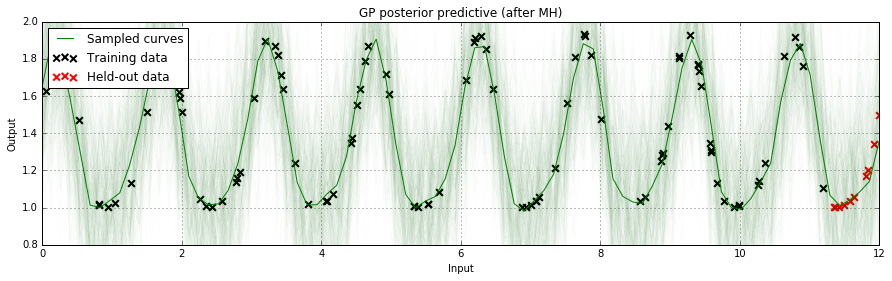

In [22]:
%%venturescript
scatter_plot(observed_input, observed_output, plotting_args_scatter);
scatter_plot(held_out_input, held_out_output, plotting_args_scatter_held_out);
for_each(
    arange(number_of_curves),
    (i) -> {
        action(
            line_plot(
                x_prime, 
                lookup(sampled_curves_after_mh, i),
                plotting_args_curves

            )
        )
    } 
);
line_plot(
    x_prime,
    get_predictive_mean(sampled_curves_after_mh),
    plotting_args_mean_of_curves
);
legend("upper left");

**Figure 2: posterior predictive after MH inference.** Above, we show the
posterior predictive of the GP after MH inference. We sampled 300 individual
curves from the GP and alpha blended the lines overlaying the predictive mean of
the curves in dark green. For both, data the GP has seen and held-out
data, the predictive performance is adequate.

### B. Gradient ascent

Gradient descent methods are amongst the most popular inference programs in machine
learning. For gradient methods, one finds optimal values by taking step proportional to
the gradient along some objective function. This objective function is often some kind of loss
function that one tries to minimize (_gradient descent_). In the Bayesian setting one
tries to estimate the maximum of the posterior - we therefore speak of _gradient ascent_.

The objective function of the GP is the defined as the log conditional of a multivariate
normal which is determined by the GP's mean and covariance function - weighted by its prior on the hyperparameters for mean and covariance function. Assume the mean
function $m(x_i) = 0$ for all $x_i$, we can write the objective function as:

$\log P(\mathbf{y} \mid \mathbf{x}, \ell, p)  + \log P(\ell, p) =
-\frac{1}{2}\mathbf{y}^\top \mathbf{K}_{\ell, p}^{-1}\mathbf{y}
- \frac{1}{2} \log \, |  \, \mathbf{K}_{\ell,p} \, |
- \frac{n}{2}\log 2\pi  + \log P(\ell, p)$

where we write $\mathbf{K}_{\ell, p}$ for the matrix of dimension $n \times n$
with entries $k(x_i,x_j \mid \ell, p)$ where $x_i$ and $x_j \in \mathbf{x}$
and $n$ indicating the length of the column vector  of 
of the observed input data $\mathbf{x}$.



In the following, we use uniform priors only for $\ell$ and  $p$. 
This simplifies the objective function to:

$\log P(\mathbf{y} \mid \mathbf{x}, \ell, p) = 
-\frac{1}{2}\mathbf{y}^\top \mathbf{K}_{\ell, p}^{-1}\mathbf{y}
- \frac{1}{2} \log \, |  \, \mathbf{K}_{\ell,p} \, |
- \frac{n}{2}\log 2\pi$.

To get the gradients, we need to get the partial derivative with respect to
$\ell$ and $p$:


$\frac{\partial}{\partial \ell} \log(P(\mathbf{y} \mid \mathbf{x}, \ell) = \frac{1}{2}
\mathbf{y}^\top \mathbf{K}^{-1} \frac{\partial \mathbf{K}}{\partial \ell}
\mathbf{K}^{-1} 
-\frac{1}{2} \text{tr} (\mathbf{K}^{-1} 
\frac{\partial \mathbf{K}}{\partial \ell})
$

and

$\frac{\partial}{\partial p} \log(P(\mathbf{y} \mid \mathbf{x}, p) = \frac{1}{2}
\mathbf{y}^\top \mathbf{K}^{-1} \frac{\partial \mathbf{K}}{\partial p}
\mathbf{K}^{-1} 
-\frac{1}{2} \text{tr} (\mathbf{K}^{-1} 
\frac{\partial \mathbf{K}}{\partial p})
$.

#### Re-fixing a specific structure

In order to compare to MH to gradient ascent. To guarantee a fair comparison between the too approaches, we reset the trace to the prior and again, fix the structure to a simple periodic base kernel.

In [23]:
%%venturescript
reset_to_prior;
set_value_at_scope_block(quote(structure), pair("branch", 1), False);
set_value_at_scope_block(quote(structure), 1, 4);
set_value_at_scope_block(
    quote(hypers),
    pair("PER_l", 1),
    logit(exp(- {7}))
);
set_value_at_scope_block(
    quote(hypers),
    pair("PER_t", 1),
    logit(exp(- {7}))
);

Note how the inference routine in the next cell differs from above. `grad_ascent(minimal_subproblem(/?hypers))`
means: take a determinstic gradient step with stepsize 0.0001 upwards to the objective function, which is the
log joint probability.

In [24]:
%%venturescript
define number_gradient_steps = 100;
define gradient_trajectory_data = mapv((i) -> run({
        l  <- sample(source[1]);
        p  <- sample(source[2]);
        grad_ascent(minimal_subproblem(/?hypers), 0.01, 1, 1);
        return([l, p])
  }),
    arange(number_gradient_steps)
);

Sample a number of curves at input $\mathbf{x}^\prime$.

In [25]:
%%venturescript
define sampled_curves_after_gradient_ascent = mapv(
    (_) -> run(sample gp(${x_prime})), arange(number_of_curves)
);

#### GP posterior predictive after gradient ascent

In [26]:
%%venturescript
define plotting_args_curves = dict(
    ["xlabel", "Input"],
    ["ylabel", "Output"],
    ["label", "Sampled curves"],
    ["title", "GP posterior predictive (after gradient ascent)"],
    ["width", 15],
    ["height", 5],
    ["height", 4],
    ["alpha", 0.01],
    ["color", "green"]
);

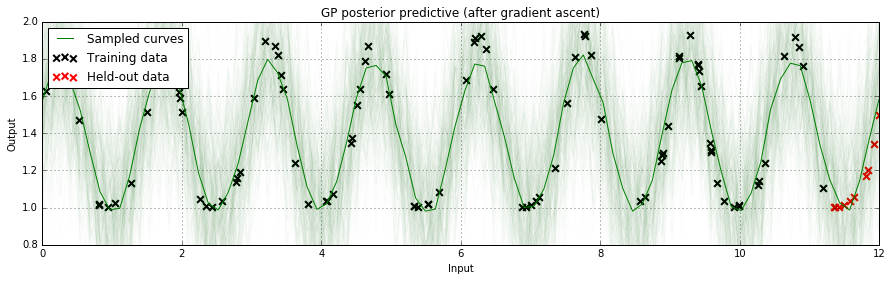

In [27]:
%%venturescript
scatter_plot(observed_input, observed_output, plotting_args_scatter);
scatter_plot(held_out_input, held_out_output, plotting_args_scatter_held_out);
for_each(
    arange(number_of_curves),
    (i) -> {
        action(
            line_plot(
                x_prime, 
                lookup(sampled_curves_after_gradient_ascent, i),
                plotting_args_curves

            )
        )
    } 
);
line_plot(
    x_prime,
    get_predictive_mean(sampled_curves_after_gradient_ascent),
    plotting_args_mean_of_curves
);
legend("upper left");

**Figure 3: posterior predictive after gradient ascent.** Above, we show the
posterior predictive of the GP after 100 steps of gradient ascent. Again, we
sampled 300 individual curves from the GP and alpha blended the lines overlaying
the predictive mean of the curves in dark green. 
As opposed to the predictive shown in Fig. 2, we see that hyperparamters found by the gradient ascent cause the predictive to miss the peaks
of the amplitude of the periodic dynamic that underlies the data.

### C. Comparison of MH and gradient ascent
The next cells unwrap the two-dimensional array of hyperparameter values generated 
above, so that they can be supplied as one dimensional lists to the plotting routines 
below.

In [28]:
%%venturescript
define mh_trajectory_lenghtscale = mapv(
    (i) -> {
        lookup(lookup(mh_trajectory_data, i), 0)
    },
    arange(size(mh_trajectory_data))
);
define mh_trajectory_period = mapv(
    (i) -> {
        lookup(lookup(mh_trajectory_data, i), 1)
    },
    arange(size(mh_trajectory_data))
);
define gradient_trajectory_lenghtscale = mapv(
    (i) -> {
        lookup(lookup(gradient_trajectory_data, i), 0)
    },
    arange(size(gradient_trajectory_data))
);
define gradient_trajectory_period = mapv(
    (i) -> {
        lookup(lookup(gradient_trajectory_data, i), 1)
    },
    arange(size(gradient_trajectory_data))
);

We precomputed the posterior landscape for speed.

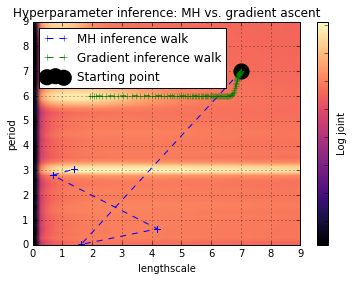

In [29]:
%%venturescript
define posterior_landscape = load_csv(
    "resources/synthetic_data/posterior_landscape.csv"
);
define heatmap_args = dict(
    ["xlabel", "lengthscale"],
    ["ylabel", "period"],
    ["title", "Hyperparameter inference: MH vs. gradient ascent"],
    ["marker", "+"],
    ["width", 20],
    ["heigth", 15]
);
square_heatmap(posterior_landscape, [0, 9], heatmap_args);
define mh_trajectory_args = dict(
    ["color", "blue"],
    ["linestyle", "--"],
    ["label", "MH inference walk"],
    ["marker", "+"]
);
line_plot(mh_trajectory_lenghtscale, mh_trajectory_period, mh_trajectory_args);
define gradient_trajectory_args = dict(
    ["color", "green"],
    ["linestyle", "--"],
    ["label", "Gradient inference walk"],
    ["marker", "+"]
);
line_plot(
    gradient_trajectory_lenghtscale,
    gradient_trajectory_period,
    gradient_trajectory_args
);
define starting_args = dict(
    ["color", "black"],
    ["label", "Starting point"],
    ["marker", "o"],
    ["markersize", 200]
);
define end_args = dict(
    ["color", "white"],
    ["label", "End points"],
    ["marker", "o"],
    ["markersize", 100]
);
scatter_plot([7], [7], starting_args);
legend("upper left");

**Figure 4: inference over posterior landscape.** The plot depicts the walk of
inference over the posteror landscape. The hyperparameters, that is lengthscale
$\ell$ and period $p$ are both initialized at 7 (black circle). 
We show the walk of MH in blue, the
ascent of the gradient is depicted in green. For both inference routines, we
show the walk that resulted from calling the inference program 100 times.
Note that for MH, 96 of the 100 proposed new coordinates for $\ell$ and $p$
are rejected, thus, the blue walk is comprised of only 4 points. The gradient
ascent on the other hand automatically accepts any step. Thus, dense plotting of
100 green + symbols resembles a thick green line at areas where the posterior
landscape is particulary flat.

## 6. References
[1]
David Duvenaud, James Lloyd, Roger Grosse, Joshua Tenenbaum, and Zoubin Ghahramani. 
Structure discovery in nonparametric regression through compositional 
kernel search. In Proceedings of the International Conference on Machine Learning (ICML), pages 1166–1174,2013.

[2]
James Lloyd, David Duvenaud, Roger Grosse, Joshua Tenenbaum, and Zoubin Ghahramani.
Automatic construction and natural-language description of nonparametric regression models.
In AAAI Conference on Artificial Intelligence, pages 1242–1250, 2014.

[3] 
Carl Rasmussen and Hannes Nickisch. Gaussian processes for machine learning (gpml) toolbox.
Journal of Machine Learning Research, 11(Nov):3011–3015, 2010.